In [4]:
#Yield Curve PCA

#1. Data preparation
%matplotlib inline
import os
import io
import time
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
from fredapi import Fred


fred = Fred(api_key='18d2f4c4ecbb09f17d84ba7bcb3740a9')  

# download CMT treasury curves from Fed
codes = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
start_date = datetime(2000, 1, 1)
end_date = datetime(2020, 12, 31)

df = pd.DataFrame()

for code in codes:
    print(f"Downloading {code}...")
    series = fred.get_series(code, observation_start=start_date, observation_end=end_date)
    df[code] = series

df.dropna(axis=0, inplace=True)
df = df['2006':]

print(f"\nData shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")


Data shape: (3754, 11)
Date range: 2006-01-03 00:00:00 to 2020-12-31 00:00:00


In [8]:
df.tail(5)

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
2020-12-24,0.09,0.09,0.09,0.10,0.13,0.17,0.37,0.66,0.94,1.46,1.66
2020-12-28,0.09,0.11,0.11,0.11,0.13,0.17,0.38,0.65,0.94,1.46,1.67
2020-12-29,0.08,0.10,0.12,0.11,0.12,0.17,0.37,0.66,0.94,1.47,1.67
2020-12-30,0.06,0.08,0.09,0.12,0.12,0.17,0.37,0.66,0.93,1.46,1.66
2020-12-31,0.08,0.09,0.09,0.10,0.13,0.17,0.36,0.65,0.93,1.45,1.65


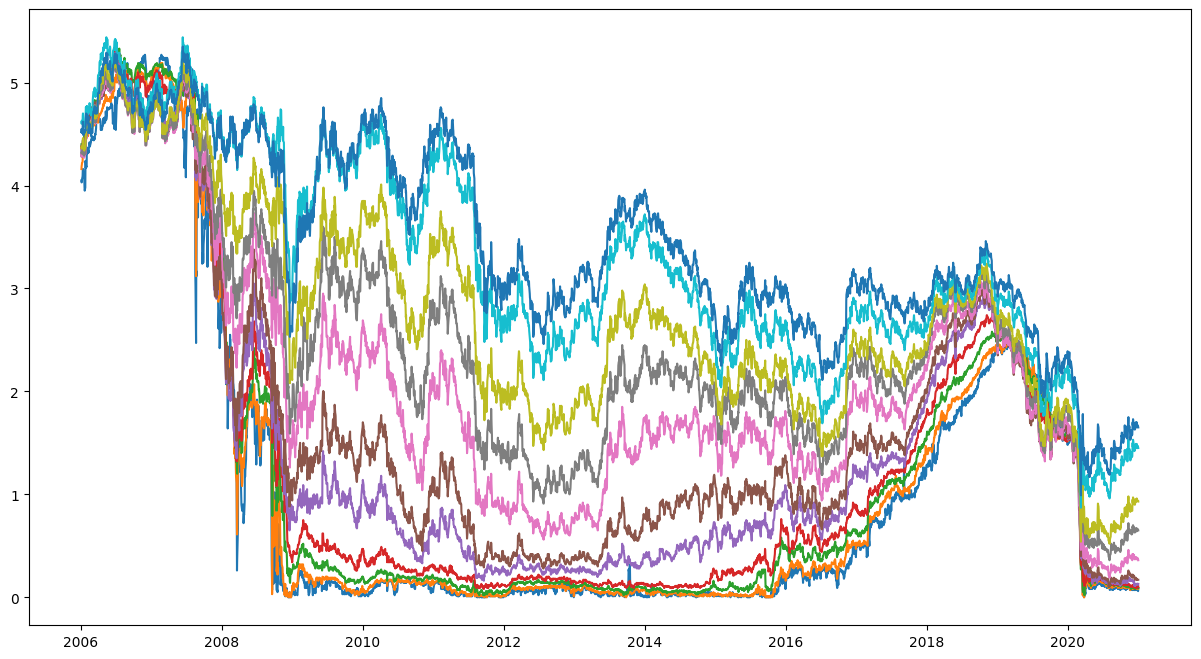

In [9]:
# view the yield curve
plt.figure(figsize=(15,8))
plt.plot(df)
plt.show()

In [10]:
	
# correlation among tenors
sns.pairplot(df)

In [11]:
df_weekly = df.resample("W").last()
df_weekly.tail()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
2020-12-06,0.07,0.09,0.10,0.11,0.16,0.21,0.42,0.70,0.97,1.53,1.73
2020-12-13,0.08,0.08,0.08,0.10,0.11,0.18,0.37,0.63,0.90,1.42,1.63
2020-12-20,0.08,0.08,0.09,0.09,0.13,0.19,0.39,0.67,0.95,1.49,1.70
2020-12-27,0.09,0.09,0.09,0.10,0.13,0.17,0.37,0.66,0.94,1.46,1.66
2021-01-03,0.08,0.09,0.09,0.10,0.13,0.17,0.36,0.65,0.93,1.45,1.65


In [12]:
df_weekly_centered = df_weekly.sub(df_weekly.mean())
df_weekly_diff = df_weekly.diff()
df_weekly_diff.dropna(inplace=True)
df_weekly_diff_centered = df_weekly_diff.sub(df_weekly_diff.mean())
df_weekly.shape, df_weekly_diff.shape

((783, 11), (782, 11))

In [13]:
# covariance
df_weekly_diff.cov()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,0.019167,0.009983,0.005387,0.004291,0.002334,0.002013,0.001763,0.001464,0.001069,0.000743,0.000696
DGS3MO,0.009983,0.008384,0.005527,0.004424,0.002884,0.002720,0.002451,0.002156,0.001813,0.001555,0.001518
DGS6MO,0.005387,0.005527,0.005567,0.004776,0.003786,0.003731,0.003562,0.003250,0.002860,0.002409,0.002357
DGS1,0.004291,0.004424,0.004776,0.005399,0.004988,0.005119,0.005011,0.004647,0.004017,0.003413,0.003212
DGS2,0.002334,0.002884,0.003786,0.004988,0.008068,0.008559,0.008978,0.008454,0.007353,0.006143,0.005593
DGS3,0.002013,0.002720,0.003731,0.005119,0.008559,0.009975,0.010819,0.010533,0.009381,0.008055,0.007361
DGS5,0.001763,0.002451,0.003562,0.005011,0.008978,0.010819,0.013197,0.013420,0.012291,0.010856,0.009954
DGS7,0.001464,0.002156,0.003250,0.004647,0.008454,0.010533,0.013420,0.014472,0.013601,0.012373,0.011495
DGS10,0.001069,0.001813,0.002860,0.004017,0.007353,0.009381,0.012291,0.013601,0.013574,0.012874,0.012209
DGS20,0.000743,0.001555,0.002409,0.003413,0.006143,0.008055,0.010856,0.012373,0.012874,0.013275,0.012838


In [14]:
# correlation
df_weekly_diff.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.787477,0.521479,0.421829,0.187672,0.145546,0.110822,0.087923,0.066302,0.046598,0.044286
DGS3MO,0.787477,1.000000,0.809054,0.657596,0.350641,0.297437,0.233021,0.195709,0.169904,0.147428,0.145992
DGS6MO,0.521479,0.809054,1.000000,0.871084,0.564924,0.500653,0.415533,0.362070,0.329003,0.280243,0.278255
DGS1,0.421829,0.657596,0.871084,1.000000,0.755684,0.697445,0.593618,0.525682,0.469193,0.403153,0.384966
DGS2,0.187672,0.350641,0.564924,0.755684,1.000000,0.954097,0.870061,0.782327,0.702655,0.593566,0.548509
DGS3,0.145546,0.297437,0.500653,0.697445,0.954097,1.000000,0.942980,0.876639,0.806219,0.699992,0.649128
DGS5,0.110822,0.233021,0.415533,0.593618,0.870061,0.942980,1.000000,0.971078,0.918296,0.820225,0.763211
DGS7,0.087923,0.195709,0.362070,0.525682,0.782327,0.876639,0.971078,1.000000,0.970365,0.892653,0.841632
DGS10,0.066302,0.169904,0.329003,0.469193,0.702655,0.806219,0.918296,0.970365,1.000000,0.959046,0.923016
DGS20,0.046598,0.147428,0.280243,0.403153,0.593566,0.699992,0.820225,0.892653,0.959046,1.000000,0.981467


In [ ]:
## Correlation looks reasonable. The further apart between two tenors, the lower their correlation would be

In [15]:
#2. Fit PCA


# PCA fit
from sklearn.decomposition import PCA
pca_level = PCA().fit(df_weekly)        # call fit or fit_transform
pca_change = PCA().fit(df_weekly_diff)

In [ ]:
#	Level is used to find the trading signals; change is used to find weights (hedge ratios)

In [16]:
print(pca_change.explained_variance_)        # eigenvalues
print(pca_change.explained_variance_ratio_)     # normalized eigenvalues (sum to 1)
print(np.cumsum(pca_change.explained_variance_ratio_))


[0.07872586 0.02802428 0.00926885 0.00443283 0.00143389 0.00093625
 0.00040641 0.00027666 0.0002018  0.00015337 0.00010808]
[0.63504845 0.22606011 0.07476791 0.03575777 0.01156656 0.00755236
 0.00327831 0.0022317  0.00162784 0.00123718 0.00087184]
[0.63504845 0.86110855 0.93587647 0.97163423 0.98320079 0.99075314
 0.99403145 0.99626315 0.99789099 0.99912816 1.        ]


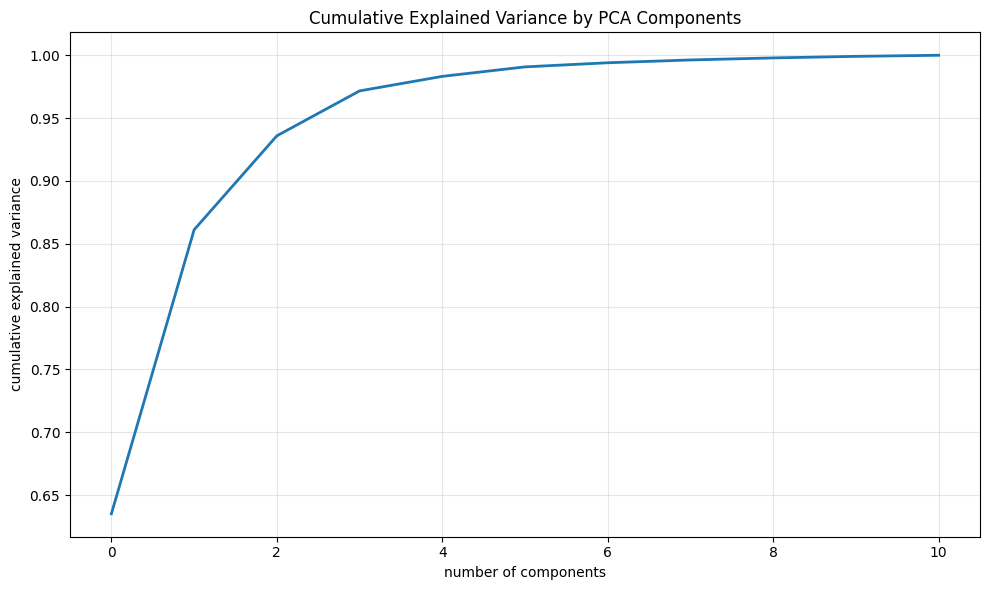


The first three PCA explain 93.59% of the total variance.


In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(pca_change.explained_variance_ratio_)), 
         pca_change.explained_variance_ratio_.cumsum(), 
         linewidth=2)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


cumvar = pca_change.explained_variance_ratio_.cumsum()
print(f"\nThe first three PCA explain {cumvar[2]*100:.2f}% of the total variance.")

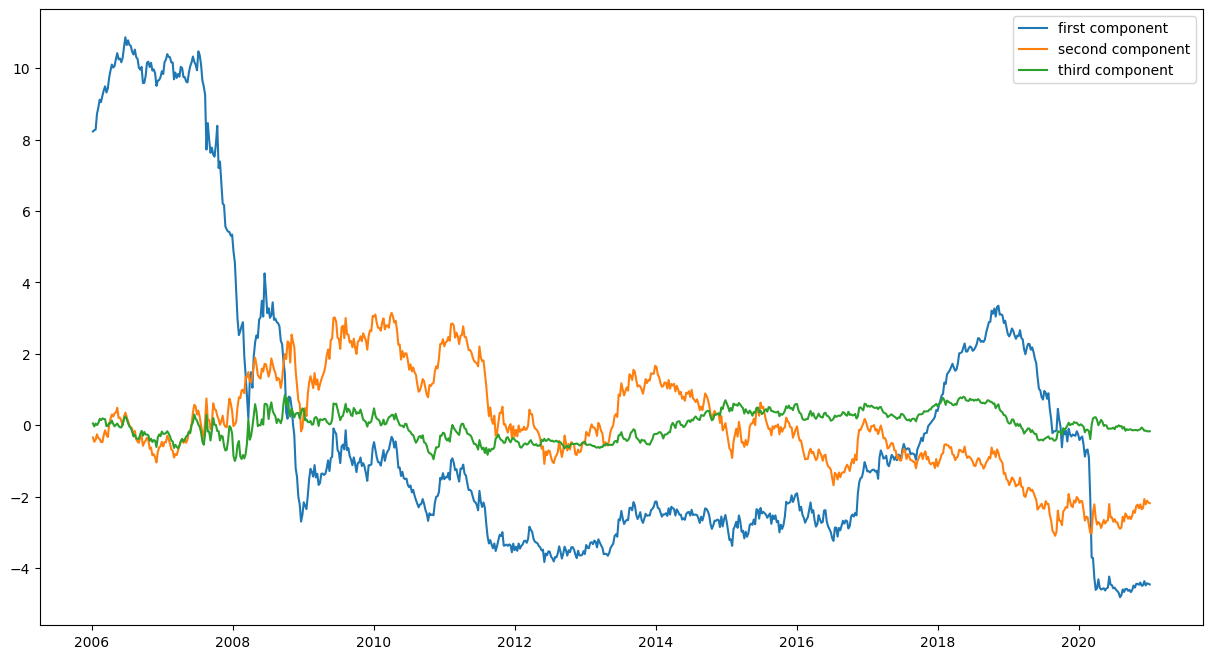

In [21]:
	
df_pca_level = pca_level.transform(df_weekly)            # T or PCs
df_pca_level = pd.DataFrame(df_pca_level, columns=[f'PCA_{x+1}' for x in range(df_pca_level.shape[1])])  # np.array to dataframe
df_pca_level.index = df_weekly.index
plt.figure(figsize=(15,8))
plt.plot(df_pca_level['PCA_1'], label='first component')
plt.plot(df_pca_level['PCA_2'], label='second component')
plt.plot(df_pca_level['PCA_3'], label='third component')
plt.legend()
plt.show()

In [ ]:
#The first PC is at its lower bound; second PC is bouncing back; third PC is trending towards its upper bound

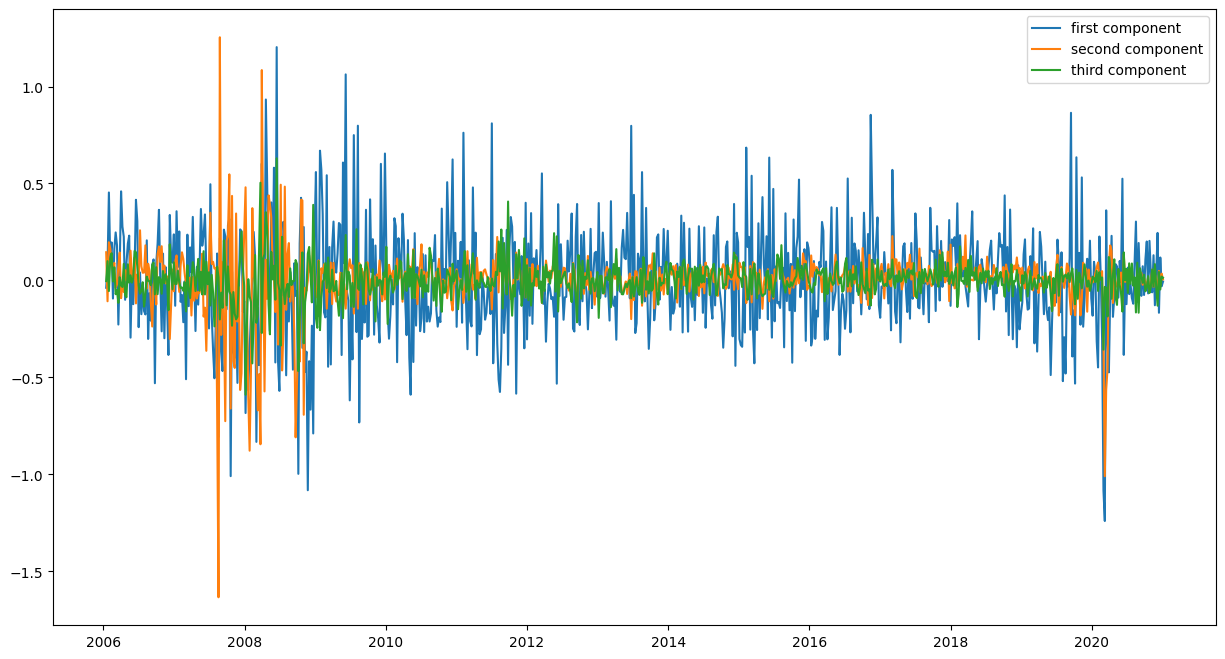

In [22]:
df_pca_change = pca_change.transform(df_weekly_diff)             # T or PCs
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PCA_{x+1}' for x in range(df_pca_change.shape[1])])  # np.array to dataframe
df_pca_change.index = df_weekly_diff.index
plt.figure(figsize=(15,8))
plt.plot(df_pca_change['PCA_1'], label='first component')
plt.plot(df_pca_change['PCA_2'], label='second component')
plt.plot(df_pca_change['PCA_3'], label='third component')
plt.legend()
plt.show()

In [ ]:
#On average, the first PC has the largest weekly changes; the second PC has the largest spike in late 2007. 
#The third PC changes are relatively smaller. This is in line with the fact that first PC explains the highest variation

In [23]:
print(pca_change.singular_values_.shape)        # SVD singular values of sigma
print(pca_change.get_covariance().shape)       # covariance
print(pca_change.components_.shape)         # p*p, W^T


(11,)
(11, 11)
(11, 11)


In [24]:
print(pca_level.components_.T[:5, :5])
print(pca_change.components_.T[:5, :5])

[[ 0.36023252 -0.25655937 -0.39913189  0.56723613 -0.01482805]
 [ 0.36796015 -0.24666686 -0.29225917  0.13972673  0.01300978]
 [ 0.374633   -0.22942481 -0.16101634 -0.26181778 -0.13081354]
 [ 0.36507482 -0.19841834  0.02053929 -0.45741015 -0.04709652]
 [ 0.33890817 -0.10331612  0.29148257 -0.31022718  0.21836308]]
[[ 0.10250026  0.75712007 -0.37420159 -0.4478502  -0.20599242]
 [ 0.11200385  0.47010396 -0.00867281  0.34676659  0.4662093 ]
 [ 0.13449477  0.28349481  0.20771456  0.51845356  0.11134675]
 [ 0.17040677  0.21223415  0.29967192  0.3449688  -0.28172845]
 [ 0.26827879  0.06440793  0.43679404 -0.12325569 -0.40230782]]


In [ ]:
#Usually PCA on level and PCA on change give different results/weights

In [25]:
print(df_pca_change.iloc[:5,:5])    # df_pca: T = centered(X) * W
print(np.matmul(df_weekly_diff_centered, pca_change.components_.T).iloc[:5, :5])     # XW

               PCA_1     PCA_2     PCA_3     PCA_4     PCA_5
2006-01-15 -0.037659  0.145471 -0.003422  0.042814  0.042772
2006-01-22  0.071417 -0.107283  0.099630  0.122137  0.022446
2006-01-29  0.453613  0.196927 -0.054567 -0.039250 -0.059868
2006-02-05  0.106102  0.164901  0.114008 -0.047069 -0.007816
2006-02-12  0.196248  0.097897  0.140442 -0.034231  0.024348
                   0         1         2         3         4
2006-01-15 -0.037659  0.145471 -0.003422  0.042814  0.042772
2006-01-22  0.071417 -0.107283  0.099630  0.122137  0.022446
2006-01-29  0.453613  0.196927 -0.054567 -0.039250 -0.059868
2006-02-05  0.106102  0.164901  0.114008 -0.047069 -0.007816
2006-02-12  0.196248  0.097897  0.140442 -0.034231  0.024348


In [ ]:
#The transform() output is T, or the first dataframe. Each volume is an eigenvector of covariance matrix X^T X

#The second dataframe should match the first, or T=XW . Here the input data X is centered but not scaled before applying SVD.
    W is pca.components_.T

In [26]:
np.matmul(pca_change.components_, pca_change.components_.T)[1,1], np.matmul(pca_change.components_.T, pca_change.components_)[1,1]



(np.float64(0.9999999999999998), np.float64(0.9999999999999994))

In [ ]:
#Eigenvector W^T is unitary (wi and wj are orthogonal)

In [28]:
print(pca_change.explained_variance_[0])      # eigenvalue
print(np.dot(np.dot(pca_change.components_[0,:].reshape(1, -1), df_weekly_diff.cov()), 
             pca_change.components_[0,:].reshape(-1, 1)))     # W^T X^TX W = lambda
print(np.dot(pca_change.components_[0,:].reshape(1, -1), df_weekly_diff.cov()))        # Ax
print(pca_change.components_[0,:]*pca_change.explained_variance_[0])                # lambda x

0.0787258649589109
[[0.07872586]]
[[0.00806942 0.0088176  0.01058822 0.01341542 0.02112048 0.02541622
  0.03097223 0.03273537 0.03145325 0.02949365 0.0279408 ]]
[0.00806942 0.0088176  0.01058822 0.01341542 0.02112048 0.02541622
 0.03097223 0.03273537 0.03145325 0.02949365 0.0279408 ]


In [ ]:
#It shows that the eigenvalues of  X^T X are explained variance. They represent the variance in the direction of the eigenvector

In [42]:
df_pca_change_123 = PCA(n_components=3).fit_transform(df_weekly_diff)     
df_pca_change_123 = pd.DataFrame(data = df_pca_change_123, columns = ['first component', 'second component', 'third component'])
print(df_pca_change_123.head(5))
print(df_pca_change.iloc[:5, :3])

   first component  second component  third component
0        -0.037659          0.145471        -0.003422
1         0.071417         -0.107283         0.099630
2         0.453613          0.196927        -0.054567
3         0.106102          0.164901         0.114008
4         0.196248          0.097897         0.140442
               PCA_1     PCA_2     PCA_3
2006-01-15 -0.037659  0.145471 -0.003422
2006-01-22  0.071417 -0.107283  0.099630
2006-01-29  0.453613  0.196927 -0.054567
2006-02-05  0.106102  0.164901  0.114008
2006-02-12  0.196248  0.097897  0.140442


In [ ]:
#Alternatively We can do fit_transform on one call. It should match the two-step fit and transform

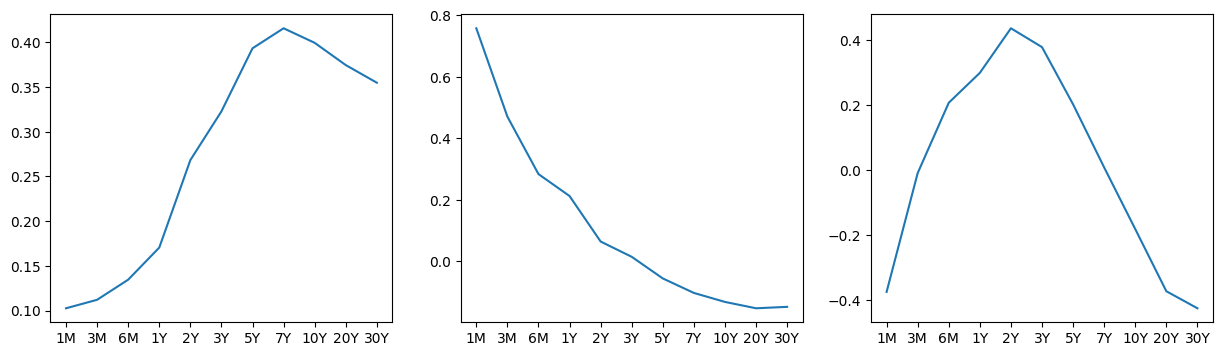

In [43]:
#3. Curve Analysis

tenors_label = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(tenors_label, pca_change.components_[0, :])
plt.subplot(132)
plt.plot(tenors_label, pca_change.components_[1, :])
plt.subplot(133)
plt.plot(tenors_label, pca_change.components_[2, :])
plt.show()

In [ ]:
#PC1 (Level): All tenors move together in the same direction (all negative loadings). Short tenors move ~0.10 bps, the peak is around 7Y at ~0.40 bps, and long tenors move ~0.35 bps. 
#This captures parallel shifts where if PC1 rises 1bps, the entire curve shifts down with 7Y moving the most.
#PC2 (Slope): Short tenors have positive loadings (0.75 for 1M) while long tenors have negative loadings (-0.10 for 10Y). 
#This represents steepening/flattening: if PC2 rises 1bps, short rates rise and long rates fall, flattening the curve.
#PC3 (Curvature): The wings (1M and 30Y) have negative loadings (~-0.40) while the belly (5Y) peaks at ~+0.45.
#This is a classic butterfly: if PC3 rises 1bps, the belly rises while both wings fall.
        

In [55]:
df_weekly_diff_centered_clean = df_weekly_diff_centered[codes]

# check the shapes
print(f"Shape df_weekly_diff_centered_clean: {df_weekly_diff_centered_clean.shape}")
print(f"Shape pca_change.components_: {pca_change.components_.shape}")

T = np.matmul(df_weekly_diff_centered_clean.values, pca_change.components_.T)  
bump_up = np.zeros(T.shape[1]).reshape(1,-1)
bump_up[0,0] = 1
bump_up = np.repeat(bump_up, T.shape[0], axis=0)
T_new = T + bump_up
df_weekly_diff_new_array = np.matmul(T_new, pca_change.components_)

df_weekly_diff_new = pd.DataFrame(
    df_weekly_diff_new_array, 
    index=df_weekly_diff_centered_clean.index,
    columns=codes
)

print("\nDifference (PC1 loadings):")
diff = df_weekly_diff_new - df_weekly_diff_centered_clean
print(diff.head())
print("\nPC1 loadings:")
print(pca_change.components_[0, :])

Shape df_weekly_diff_centered_clean: (782, 11)
Shape pca_change.components_: (11, 11)

Difference (PC1 loadings):
            DGS1MO    DGS3MO    DGS6MO      DGS1      DGS2      DGS3  \
2006-01-15  0.1025  0.112004  0.134495  0.170407  0.268279  0.322845   
2006-01-22  0.1025  0.112004  0.134495  0.170407  0.268279  0.322845   
2006-01-29  0.1025  0.112004  0.134495  0.170407  0.268279  0.322845   
2006-02-05  0.1025  0.112004  0.134495  0.170407  0.268279  0.322845   
2006-02-12  0.1025  0.112004  0.134495  0.170407  0.268279  0.322845   

                DGS5      DGS7     DGS10     DGS20     DGS30  
2006-01-15  0.393419  0.415815  0.399529  0.374637  0.354913  
2006-01-22  0.393419  0.415815  0.399529  0.374637  0.354913  
2006-01-29  0.393419  0.415815  0.399529  0.374637  0.354913  
2006-02-05  0.393419  0.415815  0.399529  0.374637  0.354913  
2006-02-12  0.393419  0.415815  0.399529  0.374637  0.354913  

PC1 loadings:
[0.10250026 0.11200385 0.13449477 0.17040677 0.26827879 0.32

In [ ]:
#To see why each column of W is the exposure, parallel shift first PC up by 1bps. 
#Then for each tenor, the move is according to the factor exposure (two prints match)

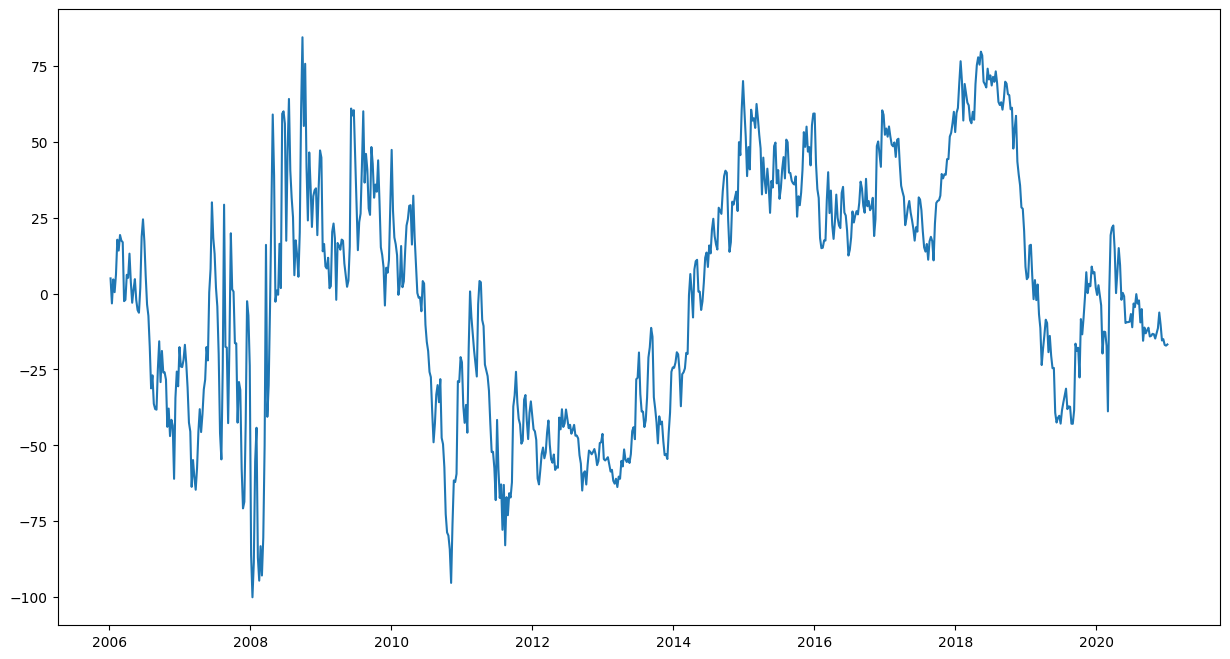

In [59]:
#4. Mean-reversion

plt.figure(figsize=(15,8))
plt.plot(df_pca_level['PCA_3']*100, label='third component')
plt.show()

In [61]:
def mle(x):
    start = np.array([0.5, np.mean(x), np.std(x)])  # starting guess

    def error_fuc(params):
        theta = params[0]
        mu = params[1]
        sigma = params[2]

        muc = x[:-1]*np.exp(-theta) + mu*(1.0-np.exp(-theta))  # conditional mean
        sigmac = sigma*np.sqrt((1-np.exp(-2.0*theta))/(2*theta))  # conditional vol

        return -np.sum(scipy.stats.norm.logpdf(x[1:], loc=muc, scale=sigmac))

    result = scipy.optimize.minimize(error_fuc, start, method='L-BFGS-B',
                                     bounds=[(1e-6, None), (None, None), (1e-8, None)],
                                     options={'maxiter': 500, 'disp': False})
    return result.x

theta, mu, sigma = mle(df_pca_level['PCA_3'])
print(theta, mu, sigma)
print(f'fly mean is {mu*100} bps')
print(f'half-life in week {np.log(2)/theta}')
print(f'annual standard deviation is {sigma/np.sqrt(2*theta)*100} bps, weekly {sigma/np.sqrt(2*theta)*100*np.sqrt(1/52)} bps')


print(f'PC1 mean: {np.mean(df_pca_change.iloc[:, 0])*100:.2f} bps, std: {np.std(df_pca_change.iloc[:, 0])*100:.2f} bps')
print(f'PC2 mean: {np.mean(df_pca_change.iloc[:, 1])*100:.2f} bps, std: {np.std(df_pca_change.iloc[:, 1])*100:.2f} bps')
print(f'PC3 mean: {np.mean(df_pca_change.iloc[:, 2])*100:.2f} bps, std: {np.std(df_pca_change.iloc[:, 2])*100:.2f} bps')

print(f'current PCA_3: {df_pca_level["PCA_3"].iloc[-1]*100:.2f}')  # current pca_3

0.04192451261722224 -0.006565022204463326 0.114728126511133
fly mean is -0.6565022204463326 bps
half-life in week 16.533219763065443
annual standard deviation is 39.62058581822344 bps, weekly 5.494386681981768 bps
PC1 mean: -0.00 bps, std: 28.04 bps
PC2 mean: 0.00 bps, std: 16.73 bps
PC3 mean: 0.00 bps, std: 9.62 bps
current PCA_3: -16.78


/var/folders/hc/xlhbrtl12c54hw9xwn6nk5fr0000gn/T/ipykernel_1068/2326539795.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = scipy.optimize.minimize(error_fuc, start, method='L-BFGS-B',


In [ ]:
#5. Butterfly

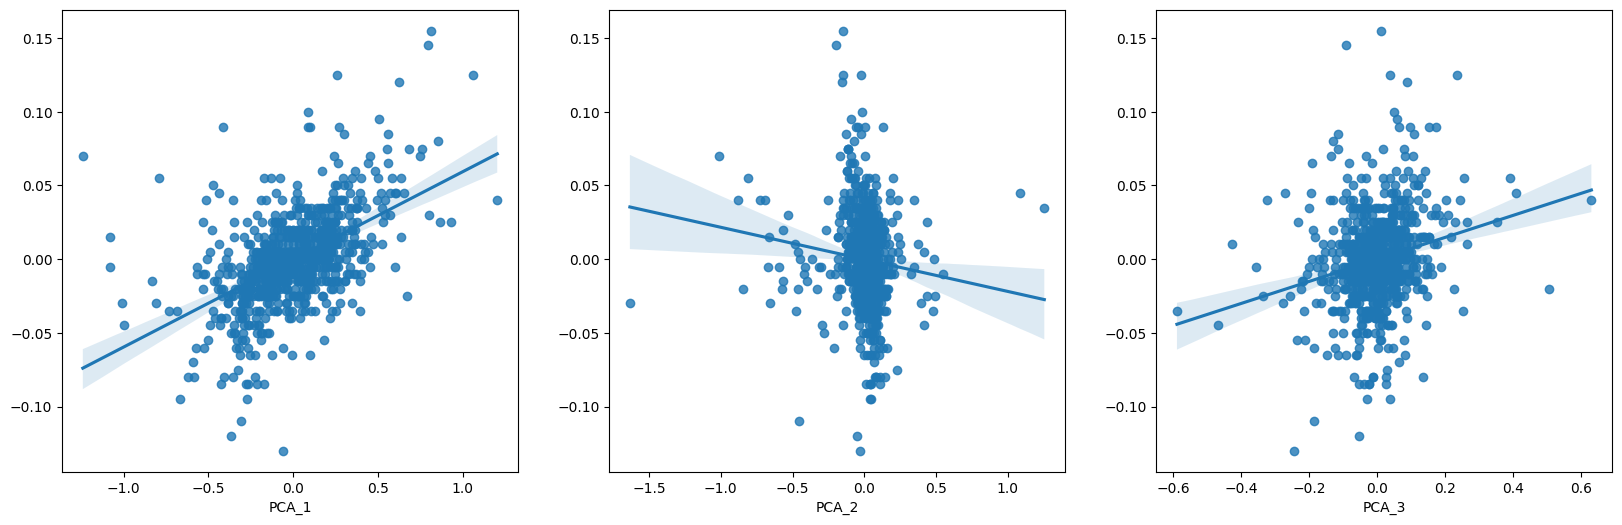

In [64]:
fly5050 = df_weekly_diff['DGS5'] - (df_weekly_diff['DGS2']+df_weekly_diff['DGS10'])/2
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=fly5050)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=fly5050)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=fly5050)
plt.show()

In [ ]:
#This is 50-50 DV01 neutral fly. It is not market value neutral.

#It has negative exposure to PC1 and positive exposure to PC2 (the linear regression coefficient is not zero)

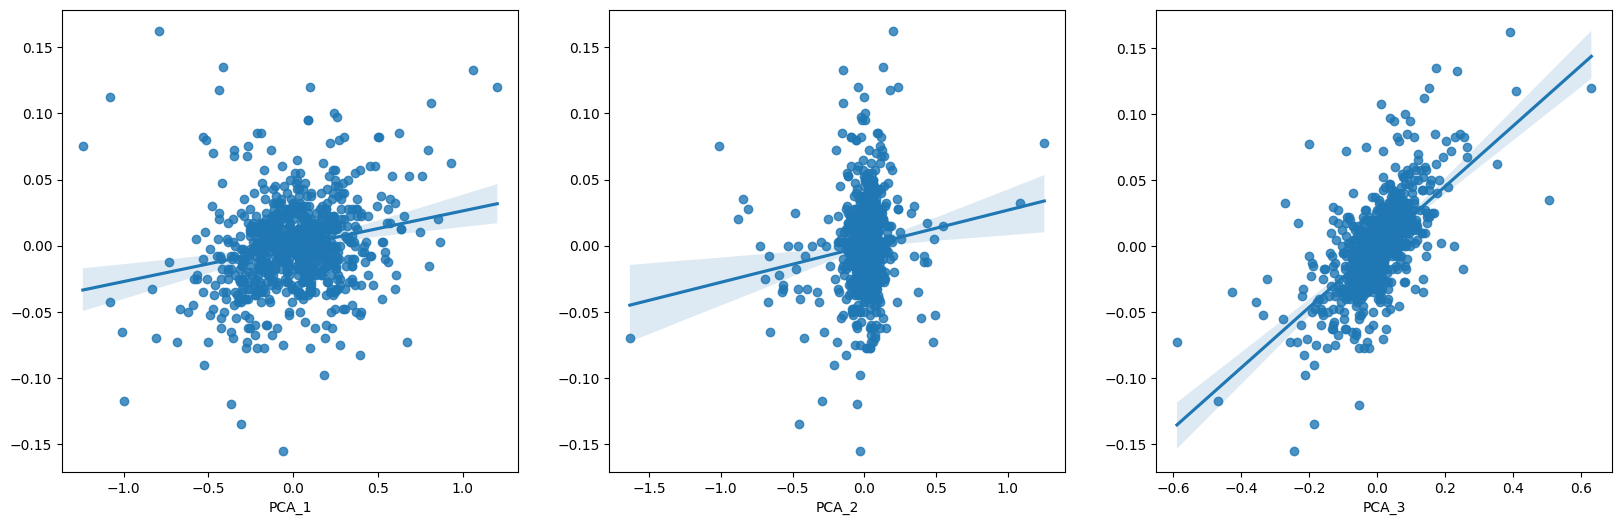

In [67]:
flymkt = df_weekly_diff['DGS5'] - (0.25*df_weekly_diff['DGS2']+0.75*df_weekly_diff['DGS10'])
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flymkt)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flymkt)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flymkt)
plt.show()

In [ ]:
#PC3 (Curvature) shows the strongest linear relationship with the butterfly trade (5Y vs 2Y/10Y wings), 
#confirming that the third principal component captures curve bowing movements, 
#while PC1 and PC2 have weaker correlations with this specific fly strategy


In [68]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = codes
w21 = W.loc['DGS2', 'PCA_1']
w22 = W.loc['DGS2', 'PCA_2']
w23 = W.loc['DGS2', 'PCA_3']

w51 = W.loc['DGS5', 'PCA_1']
w52 = W.loc['DGS5', 'PCA_2']
w53 = W.loc['DGS5', 'PCA_3']

w101 = W.loc['DGS10', 'PCA_1']
w102 = W.loc['DGS10', 'PCA_2']
w103 = W.loc['DGS10', 'PCA_3']

w551 = w51 - (w21+w101)/2.0
w552 = w52 - (w22+w102)/2.0
print(w551, w552)

0.059514884305377935 -0.021767823095657057


In [ ]:
#50-50 duration has non-zero exposures on PC1 and PC2

In [69]:
A = np.array([[w21, w101],[w22,w102]])
b_ = np.array([w51, w52])
a, b = np.dot(np.linalg.inv(A), b_)
a, b

(np.float64(0.4859957458180912), np.float64(0.6583663710956322))

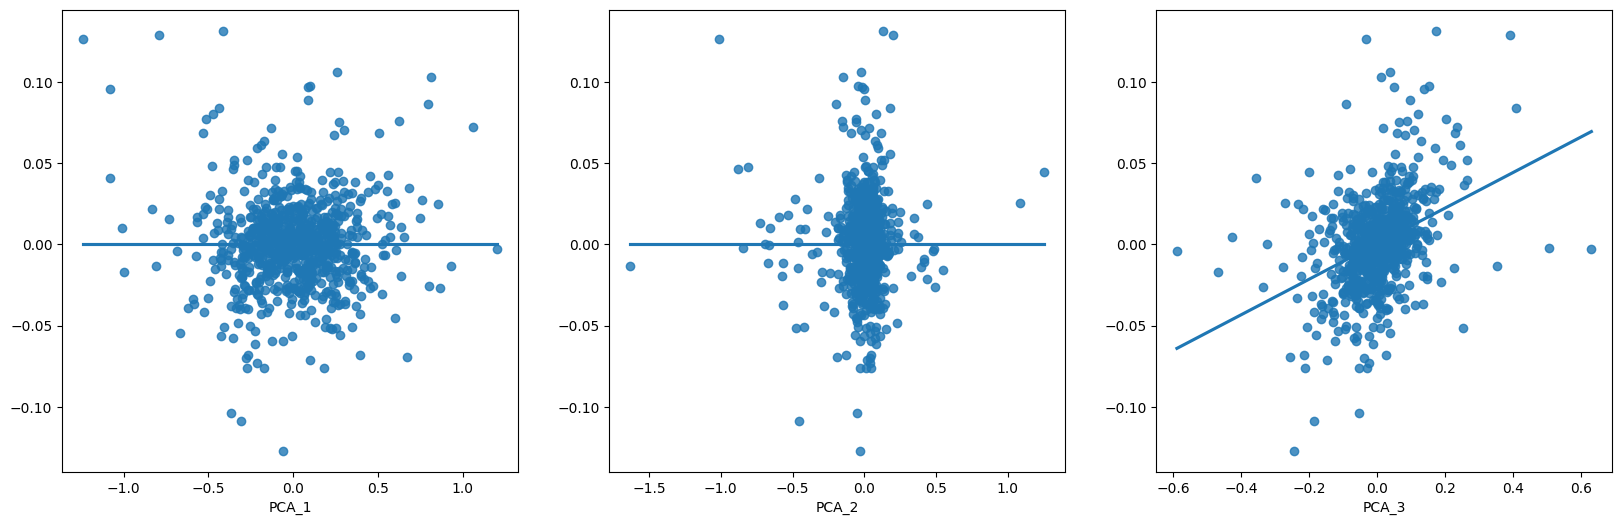

In [72]:
flypca = df_weekly_diff['DGS5']*1 - (a*df_weekly_diff['DGS2']+b*df_weekly_diff['DGS10'])
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flypca, ci=None)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flypca, ci=None)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flypca, ci=None)
plt.show()

In [ ]:
#PCA weighted fly has zero exposure to PC1 and PC2 (the line is horizontal)

slope 1: 2.5811563203673332e-17, 2: 5.596464479815362e-17, 3: 0.10950726425130004


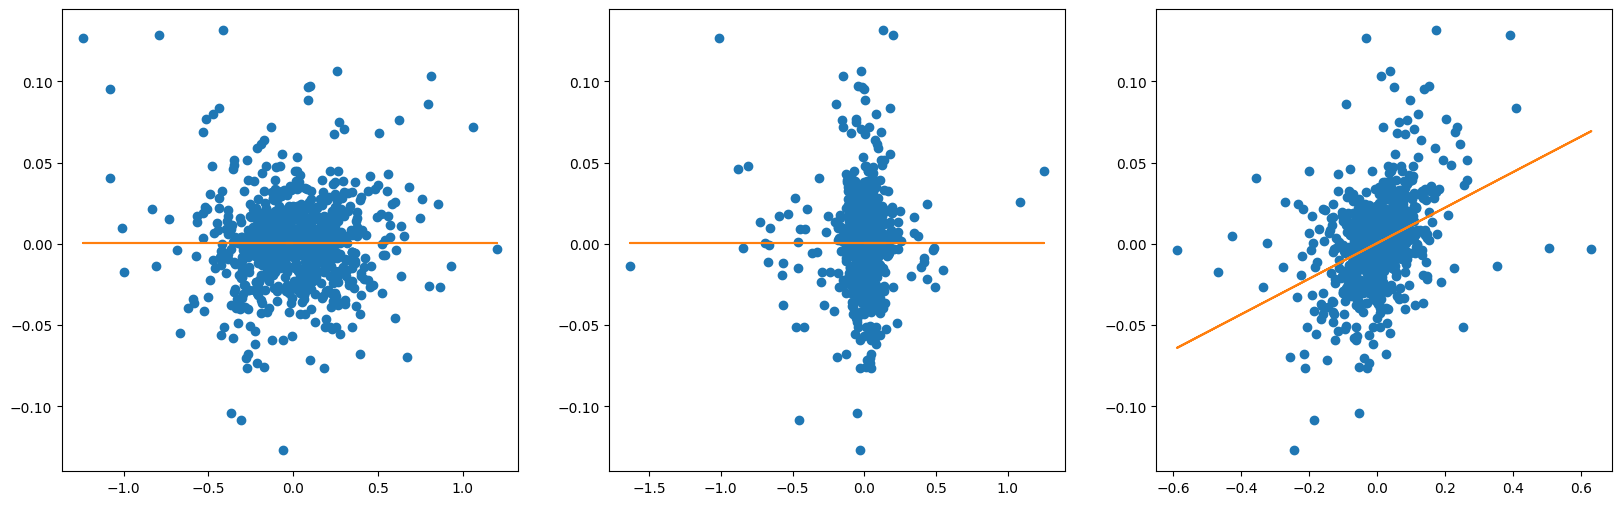

In [75]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.plot(df_pca_change['PCA_1'], flypca, 'o')
m1, b1 = np.polyfit(df_pca_change['PCA_1'], flypca, 1)
plt.plot(df_pca_change['PCA_1'], m1*df_pca_change['PCA_1']+b1)
plt.subplot(132)
plt.plot(df_pca_change['PCA_2'], flypca, 'o')
m2, b2 = np.polyfit(df_pca_change['PCA_2'], flypca, 1)
plt.plot(df_pca_change['PCA_2'], m2*df_pca_change['PCA_2']+b2)
plt.subplot(133)
plt.plot(df_pca_change['PCA_3'], flypca, 'o')
m3, b3 = np.polyfit(df_pca_change['PCA_3'], flypca, 1)
plt.plot(df_pca_change['PCA_3'], m3*df_pca_change['PCA_3']+b3)
print(f'slope 1: {m1}, 2: {m2}, 3: {m3}')
plt.show()

In [ ]:
#This is an alternative plot via matplotlib, equivalent to the sns plot above

#The print shows slopes are zero to PC1 and PC2